# Assignment 2: Feature Engineering & Linear Regression
Olivia Steed
301421820

## **Introduction**

In this assignment, you will focus on **feature engineering** and **linear regression**.

The dataset is collected from an e-commerce platform (https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset)
and includes records of user interactions with products, as well as item metadata. The main table you'll work with is the **`events`** table. It logs the **timestamp**, **user ID**, **item ID**, the type of event (`view`, `add_to_cart`, or `transaction`), and, for purchases, a **transaction ID**.

There is also an **item properties** table, which contains two main pieces of information: whether an item is **available** (denoted as 0 or 1), and a **category ID**. However, the meaning of the timestamp in this table is unclear — it could indicate when the category was assigned or when a change occurred. Additionally, a **category tree** table defines parent-child relationships between categories. Note that a category may have a parent, and that parent may have its own parent, forming a hierarchy.

---

#### Additional Notes

- If the dataset is too large to process on your machine, you may **subset the data** — for example, by limiting the number of users or items.
- You may also choose to **exclude item-weeks where no purchases occurred** (i.e., weekly purchase count is zero).
- If you face any errors while converting timestamp values to date/time (if needed), try dividing the values by **1000** — this converts them from **milliseconds to seconds**.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Restructuring the dataset
Your first task is to **restructure the dataset** to calculate the number of times each item was **successfully purchased per week**. This weekly sales count will be the **target variable** in your regression model.

First I'm going to get familiar with each dataset's contents and how they relate to each other.

In [2]:
# Load the dataset and get familiar with the event types and metadata

event_df = pd.read_csv("a2_dataset/events.csv")
item_df = pd.read_csv("a2_dataset/item_properties.csv")
category_df = pd.read_csv("a2_dataset/category_tree.csv")

**event_df** is log data from each event by timestamp including timestamp, visitorid, event type, itemid, transactionid. This can be used to get the amount of purchases per product per week by visitor, and view general visitor visiting, adding to card, and transaction behaviour. The dataset is mainly integers and floats, with objects for the event type, but this could be one-hot encoded if needed. 

In [3]:
# event_df is log data from each event by timestamp

event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [4]:
event_df.head(10)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
5,1433224086234,972639,view,22556,NaN
6,1433221923240,810725,view,443030,NaN
7,1433223291897,794181,view,439202,NaN
8,1433220899221,824915,view,428805,NaN
9,1433221204592,339335,view,82389,NaN


**item_df** is the availability and category of each item by timestamp. The timestamp meaning is uncertain so I will just be using the availability and category values. The values are mainly integers and floats except for the property value which indicates if the value column corresponds to the categoryid (kind of product) or the availability (0 = not available, 1 = available). This dataset can be liked with events_df by itemid.

In [5]:
# item_df is the availability and category of each item by timestamp. 
item_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291930 entries, 0 to 2291929
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   itemid     int64  
 2   property   object 
 3   value      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 69.9+ MB


In [6]:
item_df.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338.0
1,1436065200000,285026,available,0.0
2,1437274800000,186518,available,0.0
3,1433646000000,423682,available,0.0
4,1434250800000,316253,available,1.0
5,1437274800000,430459,available,0.0
6,1433041200000,411262,available,0.0
7,1441508400000,50372,available,0.0
8,1441508400000,289043,available,0.0
9,1435460400000,365407,available,0.0


**category_df** includes parent-child relationships between categories, and links a record's categoryid with the parent's categoryid. This could be connected to item_df by categoryid. It contains integer and float ids so will be easy to work with numerically.

In [7]:
# category_df includes parent-child relationships between categories and can be linked with parentid to categoryid (?)
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [8]:
category_df.head(10)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
5,231,NaN
6,542,378.0
7,1146,542.0
8,1140,542.0
9,1479,1537.0


Now that I understand what the datasets contain and how they connect, I'm going to restructure the data to calculate the number of times each item was successfully puchased per week as the **weekly_sales_count** value. This is indicated by transactions in the event_df table, and will be used for the regression analysis to see what raw and engineered features correlate with this value.

In [9]:
# restructure dataset to calculate the number of times each item was successfully purchased per week (transaction event)

#START[ChatGPT 4.o] "i want to restructure a dataset to get the amount of successful purchases per item per week. here is my code now but it has this error, what am i doing wrong?
# error: TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
# code: weekly_sales_count = event_df[event_df['event'] == 'purchase'].groupby(['itemid', pd.Grouper(key='timestamp', freq='W')]).size().reset_index(name='sales_count')"
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'], unit='ms')   # changing timestamp column to datetime format with milliseconds unit, otherwise all the dates will be the same
#END[ChatGPT 4.o]

# target variable for regression model
weekly_sales_count = event_df[event_df['event'] == 'transaction'].groupby(['itemid', pd.Grouper(key='timestamp', freq='W')]).size().reset_index(name='sales_count')

# check out our results
print(weekly_sales_count.head(50))


    itemid  timestamp  sales_count
0       15 2015-07-12            1
1       19 2015-08-16            1
2       25 2015-06-14            1
3       25 2015-08-09            1
4       42 2015-08-16            1
5      147 2015-09-06            4
6      168 2015-09-20            1
7      199 2015-07-19            1
8      212 2015-06-21            1
9      233 2015-06-21            1
10     304 2015-09-20            1
11     320 2015-06-21            1
12     387 2015-08-09            1
13     403 2015-06-14            1
14     496 2015-06-14            1
15     496 2015-06-21            1
16     546 2015-07-26            3
17     546 2015-08-02            5
18     546 2015-08-09            2
19     546 2015-08-16            2
20     546 2015-08-23            9
21     546 2015-08-30            2
22     563 2015-07-26            1
23     572 2015-06-21            1
24     651 2015-06-07            1
25     655 2015-08-02            1
26     698 2015-09-13            1
27     720 2015-08-2

## 2. Engineering features
Your second task is to **engineer features** from the dataset that may help predict weekly sales. You are required to create features from the following categories:

### Temporal Features (choose at least 2)

- `day_of_week`: Day when events occurred (1 = Monday, ..., 7 = Sunday)
- `week_of_month`: Week number within the calendar month
- `weeks_after_availability`: Weeks since the item became available
- `time_of_day_view/add`: Counts of views/adds during morning, afternoon, or night

First I will one-hot encode the days of the week because I am interested in when people are online shopping the most. I would assume that it is less during the week when most people are at work, and more on weekends, however online shopping is possible to do from anywhere so people could be shopping at work as well. 

In [ ]:
# encode days of the week in copy of event_df

#START[ChatGPT 4.o] "i have a dataset with timestamps in this format: 1970-01-01 00:23:53.197648801 how would i one hot encode these so there are columns for each day of the week with a 1 if it is that day and 0 if not? here is my code so far:
# event_df_copy = event_df.copy()
# event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.day_name()
# event_df_copy = pd.get_dummies(event_df_copy, columns=['day_of_week'], drop_first=True)"
# one hot encoding version
# event_df_copy = event_df.copy() # don't need to convert to timestamp again since we already did it above
# event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.day_name() # get day of the week from timestamp
# event_df_copy = pd.get_dummies(event_df_copy, columns=['day_of_week'], drop_first=False) #one-hot encode days of week
# END[ChatGPT 4.o]

event_df_copy = event_df.copy() # don't need to convert to timestamp again since we already did it above
# START[ChatGPT 4.o] "can i change this from one hot encoding to have a day of the week column with 1 for monday to 7 for sunday?"
event_df_copy['day_of_week'] = event_df_copy['timestamp'].dt.weekday + 1 # days numbered 1-7, where 1 is monday and 7 is sunday
# END[ChatGPT 4.o]

event_df_copy.head(10)

,timestamp,visitorid,event,itemid,transactionid,day_of_week
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2


To compliment the days of the week feature, I want to look into the time of day people are most actively online shopping which would be demonstrated by their views and adds to cart. This will help fill in the picture of when people are shopping the most. Comparing the views and adds to cart with the actual transactions per week will give an indication as to when people are window-shopping for entertainment or to kill time, and when they are following through on making purchases.

In [28]:
# get counts of views and adds per item per time period
# morning is 6am-12pm, afternoon is 12pm-6pm, night is 12am-6am - four even time periods of 6 hours each

# START[ChatGPT 4.o] "i have a dataset with a log of ecommerce data. i want to get counts of views and adds per item per time period. there is a timestamp column and an event column with values view, addtocart, transaction. for time periods, morning is 6am-12pm, afternoon is 12pm-6pm, night is 6pm-6am. my dataframe in python is called events_df_copy. how would i do this?"

def get_time_period(hour):
    if 0 <= hour < 6:
        return 'night'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

event_df_copy['hour'] = event_df_copy['timestamp'].dt.hour # makes hour column of time hours in 24 hr format
event_df_copy['time_of_day'] = event_df_copy['hour'].apply(get_time_period) # categorizes hour into time of day (morning, afternoon, night)

# only look at view and addtocart events
views_df = event_df_copy[event_df_copy['event'] == 'view']
adds_df = event_df_copy[event_df_copy['event'] == 'addtocart']

# Table of view counts per item per time of day
view_counts = views_df.groupby(['itemid', 'time_of_day']).size().unstack(fill_value=0)

# Table of addtocart counts per item per time of day
add_counts = adds_df.groupby(['itemid', 'time_of_day']).size().unstack(fill_value=0)

# END[ChatGPT 4.o]

event_df_copy.head(10)

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour,time_of_day
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,2,5,night
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,2,5,night
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,2,5,night
3,2015-06-02 05:12:35.914,483717,view,253185,NaN,2,5,night
4,2015-06-02 05:02:17.106,951259,view,367447,NaN,2,5,night
5,2015-06-02 05:48:06.234,972639,view,22556,NaN,2,5,night
6,2015-06-02 05:12:03.240,810725,view,443030,NaN,2,5,night
7,2015-06-02 05:34:51.897,794181,view,439202,NaN,2,5,night
8,2015-06-02 04:54:59.221,824915,view,428805,NaN,2,4,night
9,2015-06-02 05:00:04.592,339335,view,82389,NaN,2,5,night


In the above code I added labels for time of day with morning as 5am-12pm, afternoon as 12pm-7pm, and night as 7pm-5am. This allows me to see the afternoon, morning, and night activity for views and addtocarts per item in the newly created dataframes. I can also just aggregate them from the event_df_copy dataframe using the time_of_day or hour column.

In [29]:
view_counts.head(10)

time_of_day,afternoon,evening,morning,night
itemid,,,,
3,1,1,0,0
4,0,2,1,0
6,8,11,2,8
9,0,1,0,1
15,4,11,1,2
16,5,4,1,5
17,2,1,0,0
19,5,6,0,5
22,2,0,0,0


In [30]:
view_counts.describe()

time_of_day,afternoon,evening,morning,night
count,234838.000000,234838.000000,234838.000000,234838.000000
mean,2.611085,4.397184,0.831786,3.505263
std,8.391096,13.870214,2.772180,11.556773
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000
75%,2.000000,3.000000,1.000000,3.000000
max,852.000000,1267.000000,250.000000,1293.000000


This quick analysis shows us that on average, the most views per product are happening at night, as the mean is highest by far with 4.39 in the evening, compared to 0.83 views per product in the morning, 2.61 views per product in the afternoon, and 3.50 views per product at night. Let's check how this relates to the addtocart counts.

In [31]:
add_counts.head(10)

time_of_day,afternoon,evening,morning,night
itemid,,,,
15,0,3,0,0
19,0,1,0,0
25,0,1,1,2
33,0,3,0,0
42,0,1,0,1
66,1,0,0,0
102,0,1,0,0
147,4,0,0,1
168,0,0,0,1


In [32]:
add_counts.describe()

time_of_day,afternoon,evening,morning,night
count,23903.000000,23903.000000,23903.000000,23903.000000
mean,0.678199,1.205832,0.186797,0.829728
std,1.434170,2.344176,0.598682,1.684775
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000
max,65.000000,119.000000,31.000000,91.000000


The quick analysis of the addtocart counts also shows that on average, most addtocarts per product is happening in the evening, but the amount is much less, with only 1.20 add to carts per product at night compared to 0.18 add to carts per product in the morning, 0.67 add to carts per product in the afternoon, and 0.29 add to carts per product at night. It appears that the time between getting home from work and sleeping is the most popular for online shopping and purchasing, but we can look deeper into this later.

### Statistical Aggregates (choose at least 2)

- `num_of_views`, `num_of_add_to_carts`: Total count for the week
- `mean`, `std` of views/add_to_carts: Across past weeks (moving average or full history)
- `monthly_avg_views/add_to_carts`: Long-term engagement trends

In [85]:
# make new table with event_df_copy data with addtocart, transaction, view counts grouped by week

weekly_event_df = event_df_copy.copy()

# START [ChatGPT 4.o] "i want to take the dataset i have now which is log data every few minutes and aggregate the values into a row for each week of data. how would i do that?"
# timestamp will be week ending date
# weekly_event_df = (
#     event_df_copy
#     .groupby(['itemid', pd.Grouper(key='timestamp', freq='W'), 'event'])
#     .size()
#     .unstack(fill_value=0)
#     .reset_index()
# )
# weekly_event_df = weekly_event_df.sort_values(by='timestamp')
# END [ChatGPT 4.o]

## TOASK: SHOULD THIS BE BY PRODUCT OR JUST OVERALL VALUES BY WEEK? ##
# START [ChatGPT 4.o] "can it not be grouped by product id but just by week and then aggregate all the data within that week"
weekly_event_df = (
    event_df_copy
    .groupby([pd.Grouper(key='timestamp', freq='W'), 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
# END [ChatGPT 4.o]

weekly_event_df['timestamp'] = pd.to_datetime(weekly_event_df['timestamp']).dt.date

weekly_event_df.head(10)


event,timestamp,addtocart,transaction,view
0,2015-05-03,296,83,13304
1,2015-05-10,3492,1103,129180
2,2015-05-17,3642,1218,144001
3,2015-05-24,3419,1061,148034
4,2015-05-31,3520,1146,137153
5,2015-06-07,3405,1174,141866
6,2015-06-14,3081,966,127805
7,2015-06-21,4036,1316,140624
8,2015-06-28,3520,1222,136946
9,2015-07-05,3337,1089,134807


In [86]:
# mean and standard deviation of daily views, adds, and transactions per week

daily_counts = (
    event_df_copy[event_df_copy['event'].isin(['view', 'addtocart'])]
    .groupby([pd.Grouper(key='timestamp', freq='D'), 'event'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

daily_counts['week_ending'] = daily_counts['timestamp'].dt.to_period('W').apply(lambda r: r.end_time)

weekly_stats = (
    daily_counts
    .groupby('week_ending')
    .agg(
        mean_daily_views=('view', 'mean'),
        std_daily_views=('view', 'std'),
        mean_daily_addtocart=('addtocart', 'mean'),
        std_daily_addtocart=('addtocart', 'std')
    )
    .reset_index()
)

# convert week_ending to date format to match weekly_event_df so they can merge
weekly_stats['week_ending'] = pd.to_datetime(weekly_stats['week_ending']).dt.date

# Merge
weekly_event_df = weekly_event_df.merge(
    weekly_stats,
    how='left',
    left_on='timestamp',
    right_on='week_ending'
)

# Optional: drop the extra week_ending column
weekly_event_df.drop(columns='week_ending', inplace=True)

weekly_event_df.head(10)

,timestamp,addtocart,transaction,view,mean_daily_views,std_daily_views,mean_daily_addtocart,std_daily_addtocart
0,2015-05-03,296,83,13304,13304.000000,NaN,296.000000,NaN
1,2015-05-10,3492,1103,129180,18454.285714,4697.232331,498.857143,143.386922
2,2015-05-17,3642,1218,144001,20571.571429,2641.574080,520.285714,98.159249
3,2015-05-24,3419,1061,148034,21147.714286,3980.165395,488.428571,134.244624
4,2015-05-31,3520,1146,137153,19593.285714,2914.119862,502.857143,89.214028
5,2015-06-07,3405,1174,141866,20266.571429,3252.272685,486.428571,98.341001
6,2015-06-14,3081,966,127805,18257.857143,4554.762542,440.142857,119.330673
7,2015-06-21,4036,1316,140624,20089.142857,3576.700222,576.571429,170.632018
8,2015-06-28,3520,1222,136946,19563.714286,2880.310962,502.857143,112.620940
9,2015-07-05,3337,1089,134807,19258.142857,2740.018457,476.714286,55.002164


After this feature extraction, we can see the mean and standard deviation of daily views and addtocarts per week. This is different than simply dividing the totals by 7 because it captures the nuance of each day's activity. We can plot this as a time series chart to compare the totals and the computed means.

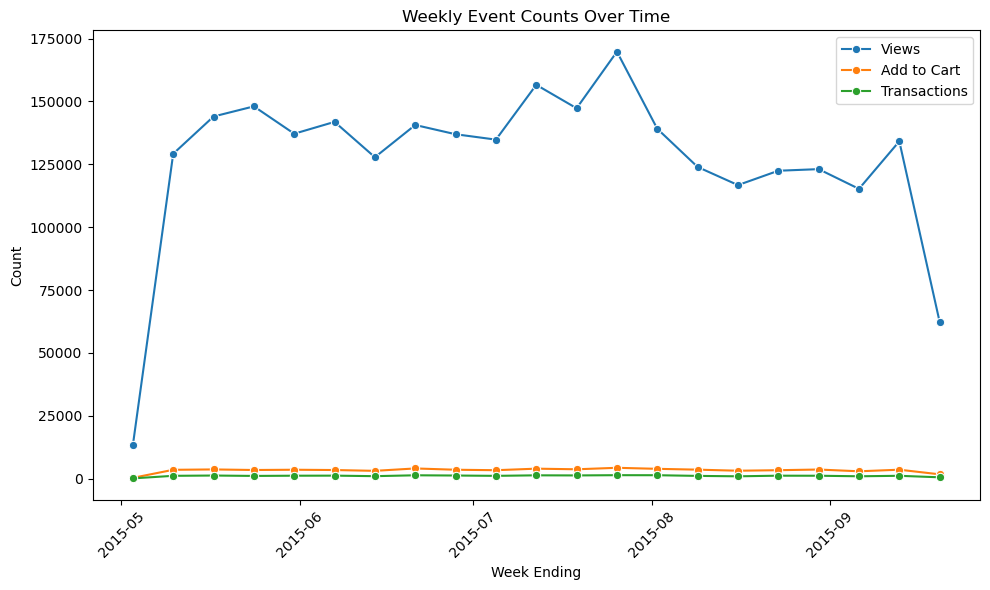

In [87]:
# show weekly_event_df data as a time series plot

# START [CoPilot]
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

# sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_views', label='mean views', marker='o')
# sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_addtocart', label='mean addtocart', marker='o')
plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# END [CoPilot]

Here we can see that views are the highest value, and the add to carts and transactions are much lower. This graph includes weekly aggregates of view, addtocart, and transaction values, so shows trends over weeks and months. It seems that views are relatively consistent, but spike in late July-early August with a dip in views after. I am assuming the first and last weeks are low because data collection started midweek, so will disregard these. The addtocart and transactions so appear to spike a bit to match with the July-August spike in views, but are far less than the view values overall.

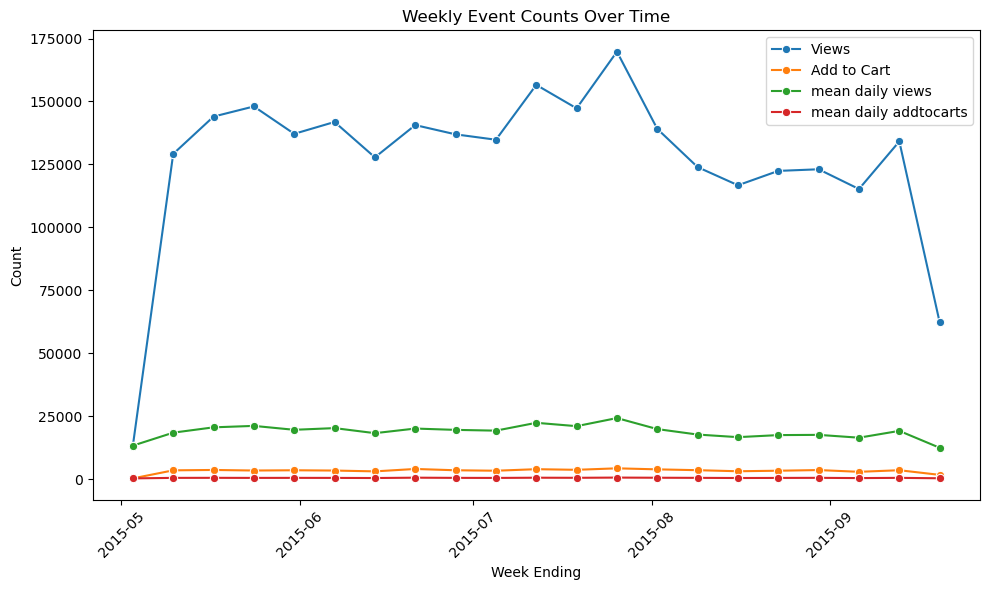

In [88]:
# show graph with daily means of views and addtocart for comparison

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
# sns.lineplot(data=weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_daily_views', label='mean daily views', marker='o')
sns.lineplot(data=weekly_event_df, x='timestamp', y='mean_daily_addtocart', label='mean daily addtocarts', marker='o')
plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In this graph, the aggregated weekly views and addtocarts are compared to the daily mean views and addtocarts. We can see that daily means are much smaller, but do reflect the overall shape of the view and addtocart data.

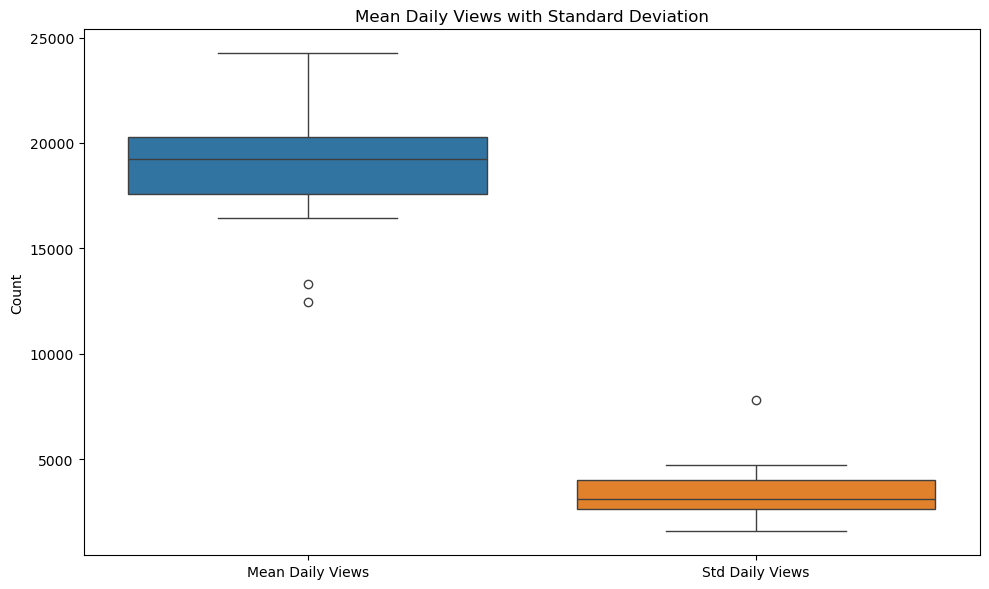

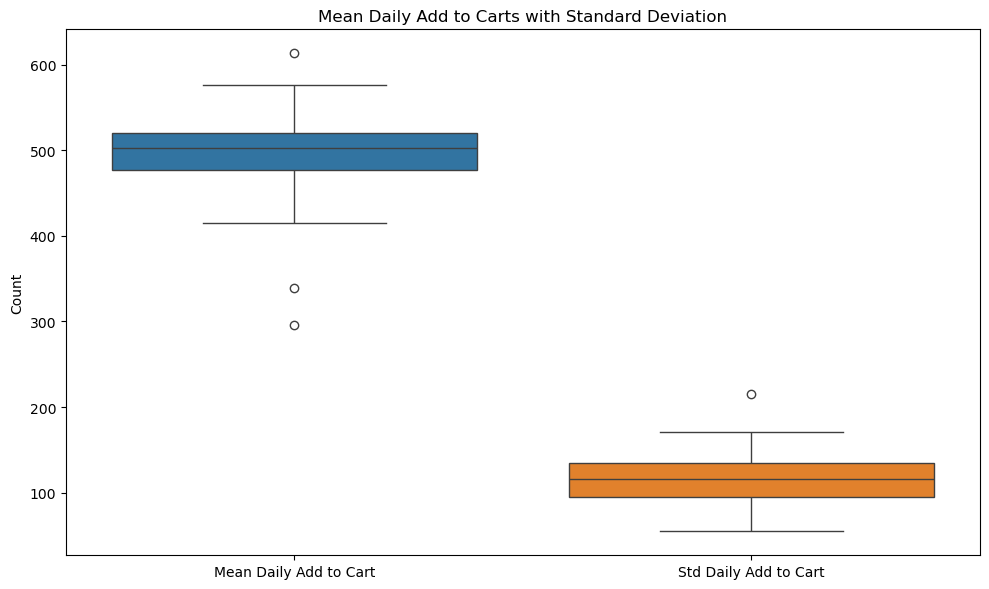

In [90]:
# make box plot of mean views and addtocarts with stadard deviation as error bars
# START [CoPilot]
plt.figure(figsize=(10, 6))
sns.boxplot(data=weekly_event_df[['mean_daily_views', 'std_daily_views']])
plt.title('Mean Daily Views with Standard Deviation')
plt.ylabel('Count')
plt.xticks([0, 1], ['Mean Daily Views', 'Std Daily Views'])
plt.tight_layout()
plt.show()
# END [CoPilot]

plt.figure(figsize=(10, 6))
sns.boxplot(data=weekly_event_df[['mean_daily_addtocart', 'std_daily_addtocart']])
plt.title('Mean Daily Add to Carts with Standard Deviation')
plt.ylabel('Count')
plt.xticks([0, 1], ['Mean Daily Add to Cart', 'Std Daily Add to Cart'])
plt.tight_layout()
plt.show()

These boxplots show some high and low outliers in the addtocart and views values, which I expect are the beginning and end values, as well as the July-August spike. I will remove the first and last values from the dataset to compare accuracy when we begin using the regression model.

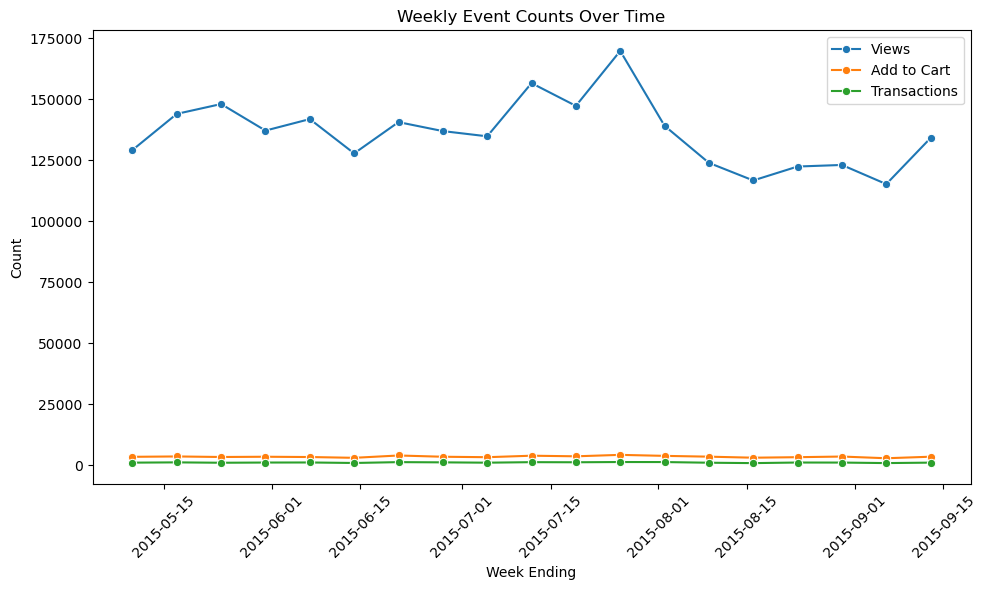

In [91]:
# drop first and last row of weekly_event_df to remove incomplete weeks
# START [CoPilot]
cleaned_weekly_event_df = weekly_event_df.iloc[1:-1].reset_index(drop=True)
# END [CoPilot]

# check if they are removed
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='view', label='Views', marker='o')
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='addtocart', label='Add to Cart', marker='o')
sns.lineplot(data=cleaned_weekly_event_df, x='timestamp', y='transaction', label='Transactions', marker='o')

plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



This cleaned dataframe is a better indication of the values since it doesn't have the midweek collection start and end artifacts biasing the data.

### Contextual / Item-Level Features (optional)

- `availability_weeks`: Weeks since the item first became available
- `num_of_sales_for_parent_category_per_week`: Aggregated sales of all items in the same parent category

In [ ]:
# insert if i have time

### Engagement Ratios (choose at least 1)

- **Add-to-cart to view ratio**:  
  \[
  \text{ratio} = \frac{\text{num add to cart}}{\text{num views} + 1}
  \]

- **Category-level engagement**:  
  Ratio of add-to-carts to views at the parent category level

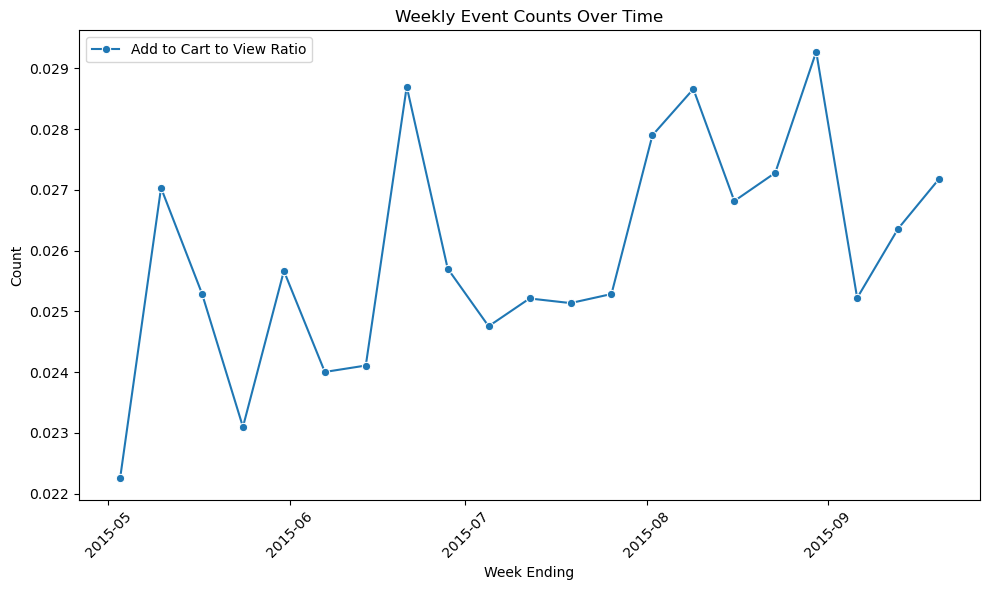

In [98]:
# calculate add to cart to view ratio for weekly_event_df

weekly_event_df['addtocart_to_view_ratio'] = (
    weekly_event_df['addtocart'] / weekly_event_df['view']
).replace([np.inf, -np.inf], np.nan)  # replace inf values with NaN

weekly_event_df.head(10)

# plot ratio over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_event_df, x='timestamp', y='addtocart_to_view_ratio', label='Add to Cart to View Ratio', marker='o')

plt.title('Weekly Event Counts Over Time')
plt.xlabel('Week Ending')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



To explore how the view number impacts the number of times items are added to cart, we can compute the add to cart to view ratio by dividing the number of times an item is added to the cart by the number of views. I added this to the existing weekly_event_df dataset with the other weekly aggregates, means, and standard deviations. The plot shows that the ratio changes over time, but within a very small range of 0.022 to 0.029, so in actuality stays relatively consistent.

### Recency Features (choose at least 1)

- Days since last view or add-to-cart
- Was the item viewed/added this week? (binary feature)

In [ ]:
# 



### Diversity of Audience (choose at least 1)

- Number of **unique users** who viewed or added the item this week
- Number of **returning users** who interacted with it in previous weeks (*may be more challenging*)

In [16]:
# code

### Your Suggested Features (propose and use 2)

Propose at **least two other features** that you think would give you an edge for better prediction. Try them to complement or replace some of the other features. 

In [17]:
# code

## 3. Regression Task

a. Start by creating a **baseline model** using only `weekly_views` and `weekly_add_to_cart` as features.

In [84]:
# we are interested in the number of successful purchases per item per week

# reviewing what we got earlier
print(weekly_sales_count.head(50))

    itemid  timestamp  sales_count
0       15 2015-07-12            1
1       19 2015-08-16            1
2       25 2015-06-14            1
3       25 2015-08-09            1
4       42 2015-08-16            1
5      147 2015-09-06            4
6      168 2015-09-20            1
7      199 2015-07-19            1
8      212 2015-06-21            1
9      233 2015-06-21            1
10     304 2015-09-20            1
11     320 2015-06-21            1
12     387 2015-08-09            1
13     403 2015-06-14            1
14     496 2015-06-14            1
15     496 2015-06-21            1
16     546 2015-07-26            3
17     546 2015-08-02            5
18     546 2015-08-09            2
19     546 2015-08-16            2
20     546 2015-08-23            9
21     546 2015-08-30            2
22     563 2015-07-26            1
23     572 2015-06-21            1
24     651 2015-06-07            1
25     655 2015-08-02            1
26     698 2015-09-13            1
27     720 2015-08-2

b. Then, add your engineered features in **different combinations**, and compare the results using metrics like **RMSE** and **R²**. For each model, reflect on:

- Why each feature might have a **positive**, **negative**, or **no impact** on the target
- You may need to use correlation, distributions, or explore other solutions to support your reasoning. 

In [19]:
# code